# Decision Tree Model

In [12]:
# import necessary packages

import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
# TODO: modell mit eurem ersetzen
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
# read data

train_df = pd.read_csv('data/preprocessed_data/train.csv')
val_df = pd.read_csv('data/preprocessed_data/validation.csv')
test_df = pd.read_csv('data/preprocessed_data/test.csv')
corona_df = pd.read_csv('data/preprocessed_data/corona.csv')

In [3]:
# split data

X_train = train_df.drop(columns='count')
y_train = train_df['count']

X_val = val_df.drop(columns='count')
y_val = val_df['count']

X_test = test_df.drop(columns='count')
y_test = test_df['count']

X_corona = corona_df.drop(columns='count')
y_corona = corona_df['count']

In [4]:
# hyperparameter tuning

try:
    # TODO: file-name ersetzen (in diesem File werden die Ergebnisse des Hyperparameter Tuning gespeichert)
    hyperparameters_df = pd.read_csv('data/hyperparameter_tuning/decision_treeTEST.csv')
    
except FileNotFoundError:
    
    # df containing hyperparameters and evaluation metrics of each run
    hyperparameters_df = pd.DataFrame()
    
    # this function is used by optuna to tune the hyperparameters
    def objective(trial):
        # TODO: die Hyperparameter mit denen eures Modells ersetzen
        # - integers: trial.suggest_int(name, low, high)
        # - floats: trial.suggest_int(name, low, high)
        # - kategorisch: trial.suggest_categorical(name, choices)
        # (https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html)
        
        # define hyperparameters
        # criterion=absolute_error takes long to calculate
        #criterion = trial.suggest_categorical('criterion', ['squared_error','friedman_mse','absolute_error','poisson'])
        criterion = trial.suggest_categorical('criterion', ['squared_error','friedman_mse','poisson'])
        splitter = trial.suggest_categorical('splitter', ['best','random'])
        max_depth = trial.suggest_int('max_depth', 1, 50)
        
        # TODO: mit eurem Modell ersetzen
        # setup and train model
        dt_reg = DecisionTreeRegressor(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth
        )
        dt_reg.fit(X_train, y_train)
        
        # make predictions
        y_val_pred = dt_reg.predict(X_val)
        
        # evaluate predictions
        r_squared = r2_score(y_val, y_val_pred)
        rmse = mean_squared_error(y_val, y_val_pred) ** 0.5
        
        # TODO: mit euren Hyperparametern ersetzen
        # insert results in dataframe
        global hyperparameters_df 
        hyperparameters_df = hyperparameters_df.append(
            {'criterion': criterion,
             'splitter': splitter,
             'max_depth' : max_depth,
             'r_squared': r_squared,
             'rmse': rmse},
            ignore_index=True
        )
        
        # return rmse -> optuna will optimize rmse
        return rmse
        
        
    study = optuna.create_study()
    # start optimization
    study.optimize(objective, n_trials=25)
    
    # TODO: evtl. müsst ihr auch noch mal die Datentypen anpassen
    # convert to correct data types
    #hyperparameters_df[['n_estimators', 'max_depth']] = hyperparameters_df[['n_estimators', 'max_depth']].astype('int')
    
    # sort hyperparameter tuning results and save file
    hyperparameters_df = hyperparameters_df.sort_values('rmse', ascending=True)
    hyperparameters_df = hyperparameters_df.reset_index(drop=True)
    hyperparameters_df.to_csv('data/hyperparameter_tuning/decision_tree.csv', index=False)

[I 2022-11-27 12:05:08,458] A new study created in memory with name: no-name-61d3b9b6-7a6f-42a5-92c7-05cea27c8a88
C:\Users\danie\AppData\Local\Temp\ipykernel_8676\655253335.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperparameters_df = hyperparameters_df.append(
[I 2022-11-27 12:05:09,299] Trial 0 finished with value: 22.757806575530324 and parameters: {'criterion': 'squared_error', 'splitter': 'random', 'max_depth': 4}. Best is trial 0 with value: 22.757806575530324.
C:\Users\danie\AppData\Local\Temp\ipykernel_8676\655253335.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperparameters_df = hyperparameters_df.append(
[I 2022-11-27 12:05:09,879] Trial 1 finished with value: 22.647548813915197 and parameters: {'criterion': 'squared_error', 'splitter': 'best', 'max_depth': 2}. Best is trial 1 wi

C:\Users\danie\AppData\Local\Temp\ipykernel_8676\655253335.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperparameters_df = hyperparameters_df.append(
[I 2022-11-27 12:05:55,915] Trial 18 finished with value: 16.47838529804219 and parameters: {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 17}. Best is trial 15 with value: 16.182189323593935.
C:\Users\danie\AppData\Local\Temp\ipykernel_8676\655253335.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyperparameters_df = hyperparameters_df.append(
[I 2022-11-27 12:05:59,954] Trial 19 finished with value: 25.699938695141988 and parameters: {'criterion': 'poisson', 'splitter': 'best', 'max_depth': 15}. Best is trial 15 with value: 16.182189323593935.
C:\Users\danie\AppData\Local\Temp\ipykernel_8676\655253335.py:46: FutureWarning: The fra

In [5]:
hyperparameters_df.head()

,criterion,splitter,max_depth,r_squared,rmse
0,friedman_mse,best,18,0.628618,15.993812
1,friedman_mse,best,18,0.625149,16.068329
2,friedman_mse,best,16,0.619818,16.182189
3,friedman_mse,best,19,0.619781,16.182980
4,friedman_mse,best,14,0.617457,16.232354


Note: If splitter=random is optimal hyperparameter, final model evaluation can turn out worse than what was achieved in optimazation (due to randomness).
Vllt. beim optimieren immer als Zwischenstand das aktuell beste Modell speichern?

In [6]:
# final model evaluation

# TODO: mit eurem Modell und Hyperparametern ersetzen
# build and train model using the most successful hyperparameters
dt_reg = DecisionTreeRegressor(
    criterion=hyperparameters_df.loc[0, 'criterion'],
    splitter=hyperparameters_df.loc[0, 'splitter'],
    max_depth=hyperparameters_df.loc[0, 'max_depth']
)
dt_reg.fit(X_train, y_train)

# make predictions
y_test_pred = dt_reg.predict(X_test)

# evaluate predictions
r_squared = r2_score(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5

print(f'R^2:\t{r_squared}')
print(f'RMSE:\t{rmse}')

R^2:	0.4471579177571262
RMSE:	19.773242852767574


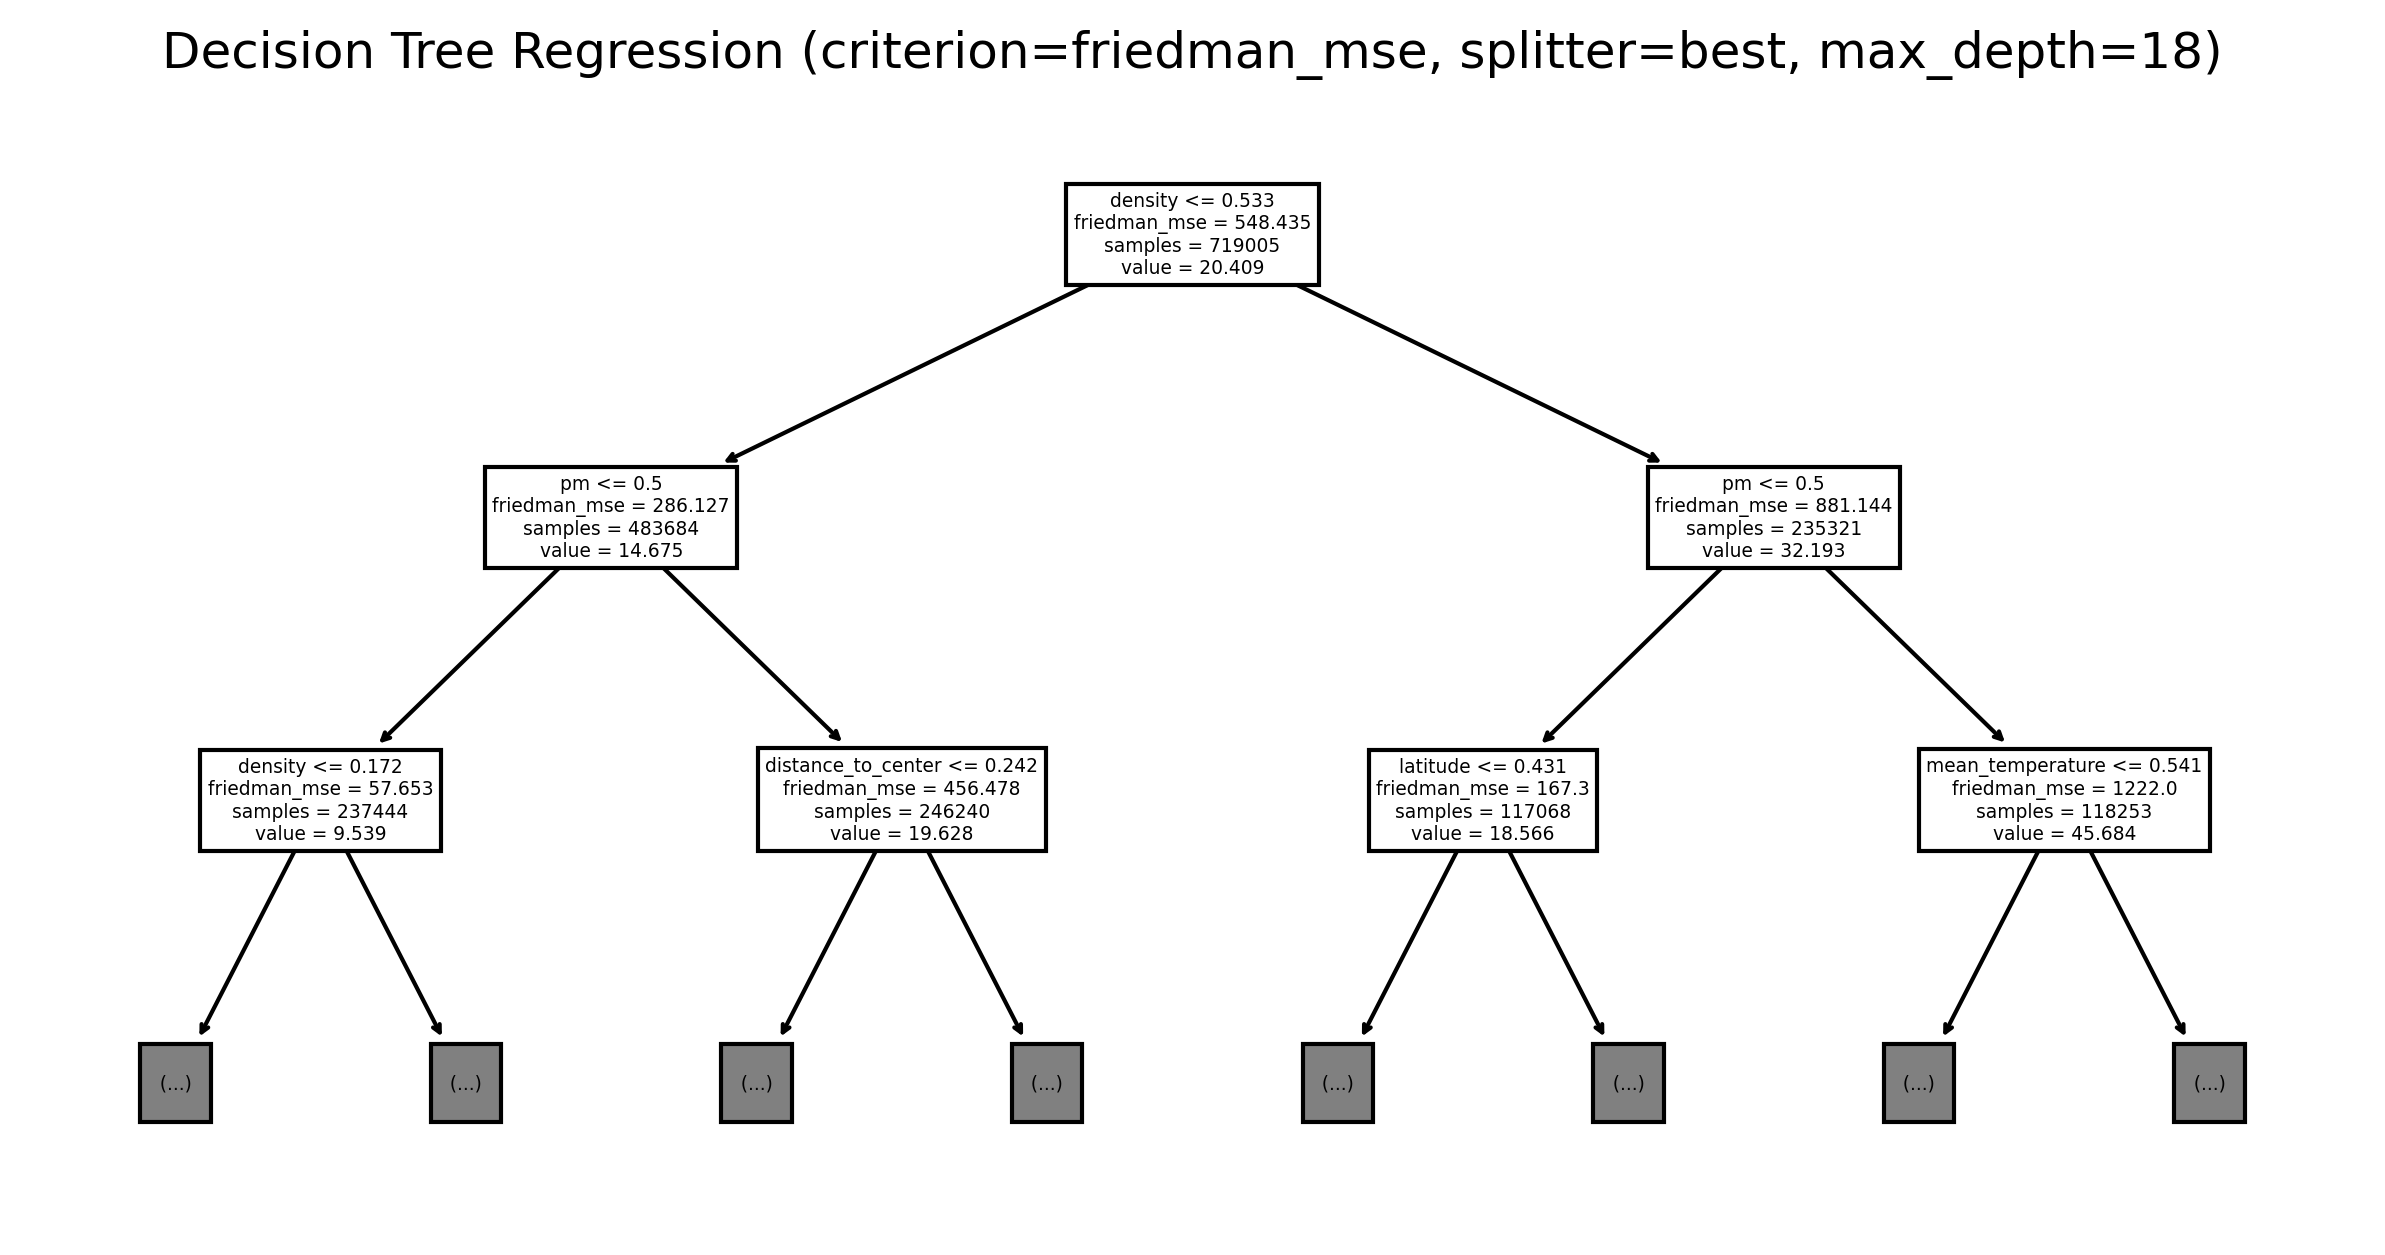

In [30]:
#plot decision tree
plt.figure(figsize=[10,5], dpi=300)
plot_tree(
    dt_reg, max_depth=2,
    feature_names=X_train.columns,
    
)

criterion=hyperparameters_df.loc[0, 'criterion']
splitter=hyperparameters_df.loc[0, 'splitter']
max_depth=hyperparameters_df.loc[0, 'max_depth']

plt.title(f"Decision Tree Regression (criterion={criterion}, splitter={splitter}, max_depth={max_depth})")
plt.show()

In [31]:
# predictions on corona year 2020

# make predictions
y_corona_pred = dt_reg.predict(X_corona)

# evaluate predictions
r_squared_c = r2_score(y_corona, y_corona_pred)
rmse_c = mean_squared_error(y_corona, y_corona_pred) ** 0.5

print(f'R^2:\t{r_squared_c}')
print(f'RMSE:\t{rmse_c}')

R^2:	-1.203449121480236
RMSE:	23.23830195143481
